In [2]:
# ## Time Series Forecasting using Tensorflow/Keras/RNN Example

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import pmdarima as pm
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import math

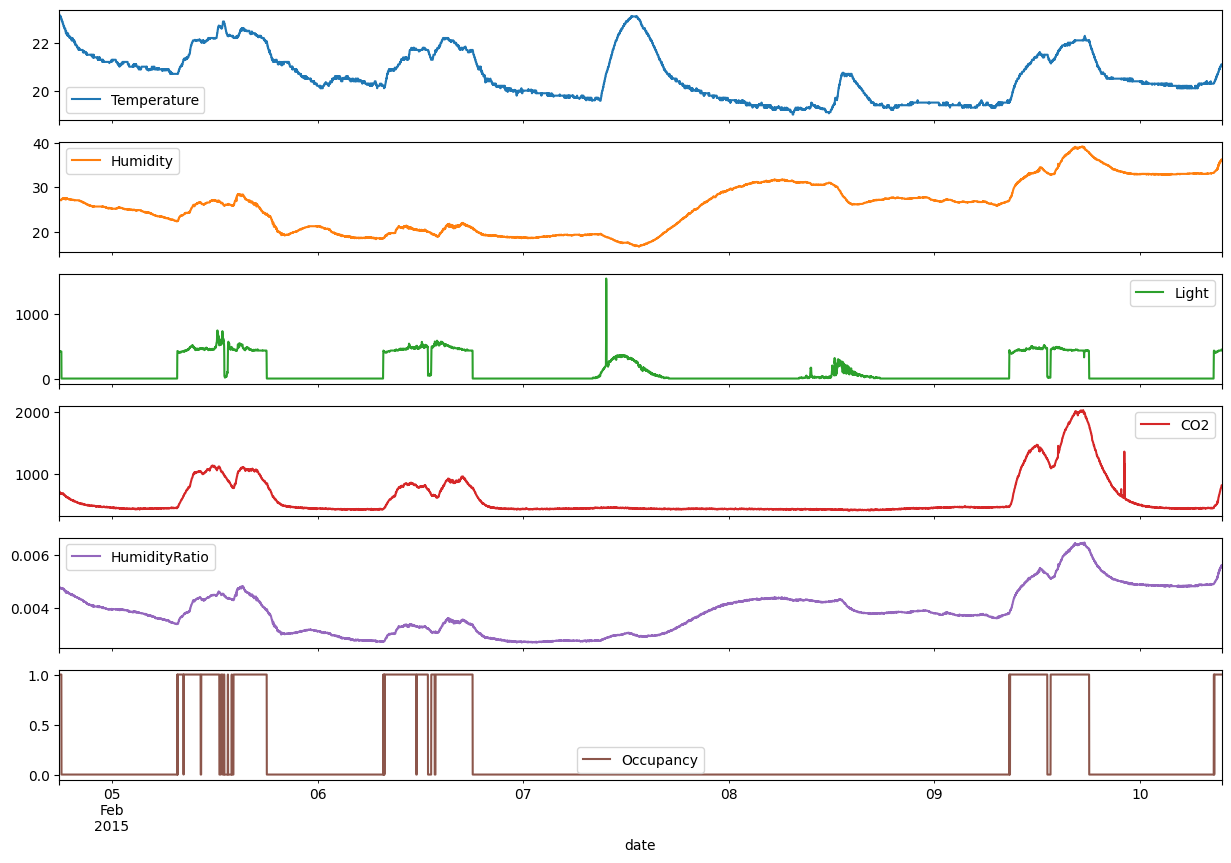

s^2 + k^2=975.745, p=0.000
Data does NOT look Gaussian (reject H0)
Kurtosis of normal distribution: -0.8104818088673884
Skewness of normal distribution: 0.4507854277580047


C:\Users\yhan8\AppData\Local\Temp\ipykernel_31596\2854138138.py:48: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(series);


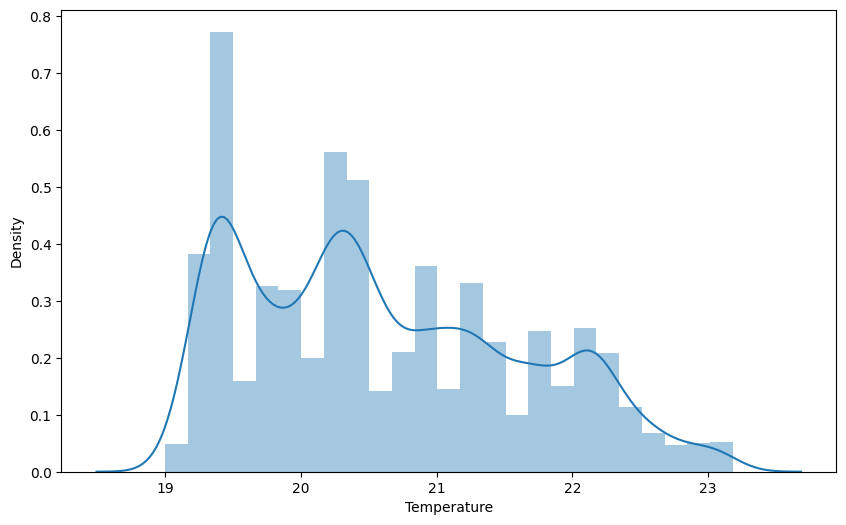

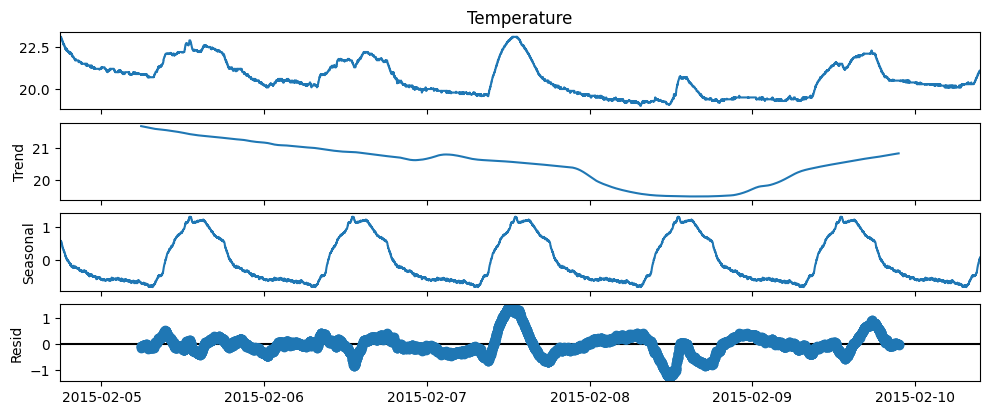

ADF Statistic: -2.694434
p-value: 0.075006
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Data has unit root and is NOT stationary (fail to reject H0)


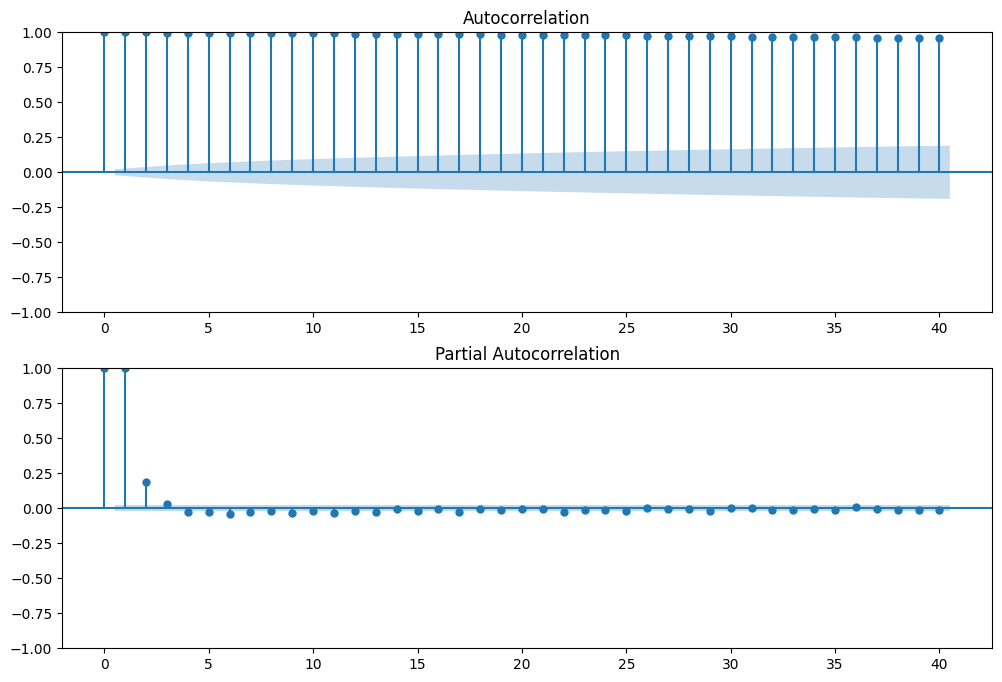

s^2 + k^2=3913.528, p=0.000
Data does NOT look Gaussian (reject H0)
Kurtosis of normal distribution: 5.771128658822981
Skewness of normal distribution: 2.3804709366949415


C:\Users\yhan8\AppData\Local\Temp\ipykernel_31596\2854138138.py:48: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(series);


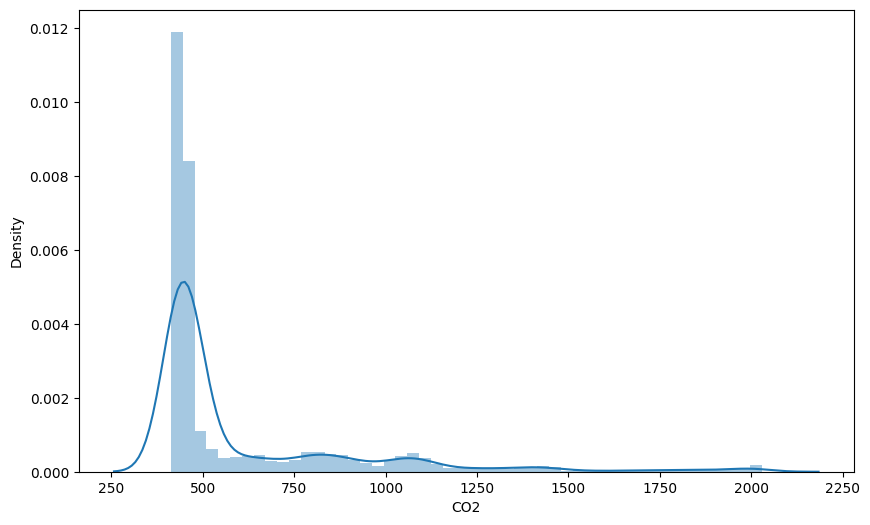

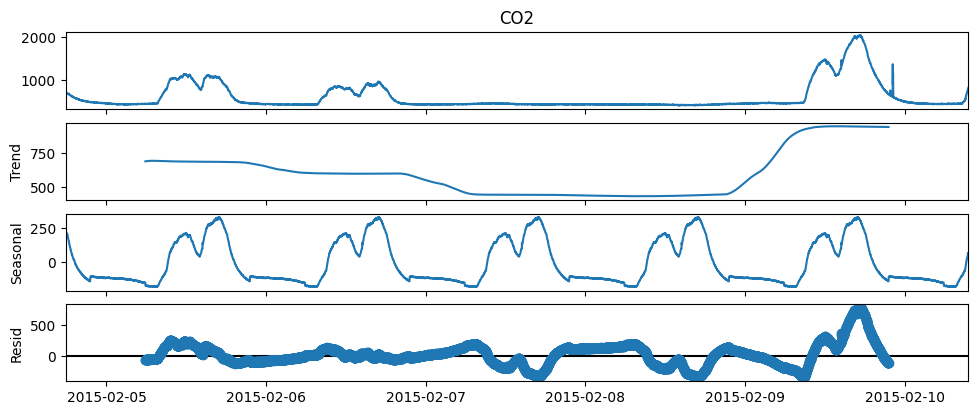

ADF Statistic: -3.639003
p-value: 0.005058
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Data does not have unit root and IS stationary (reject H0)


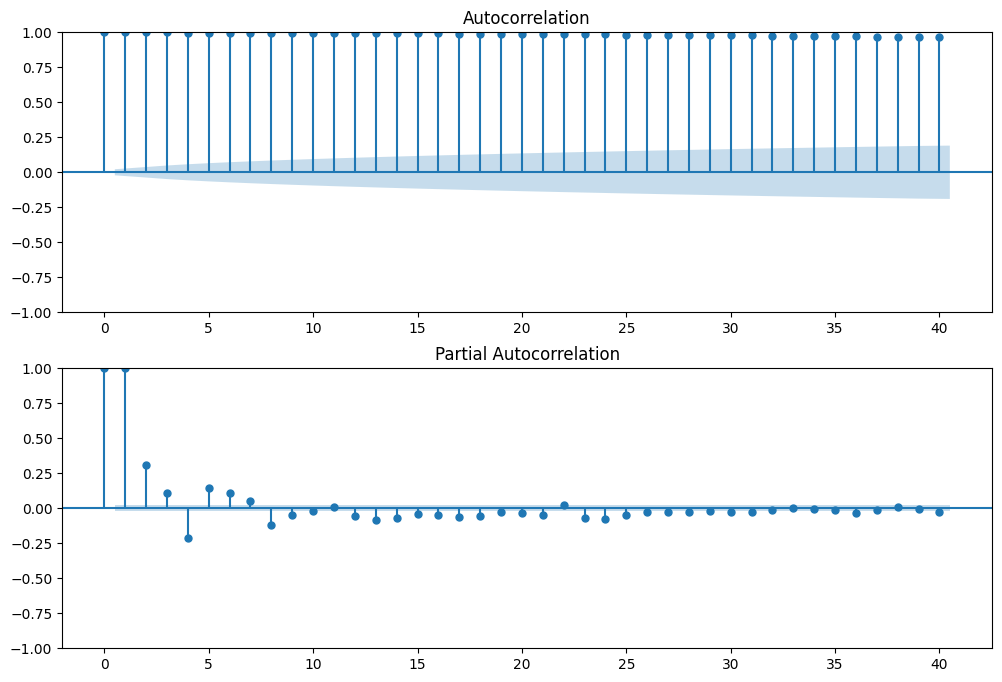

s^2 + k^2=1318.065, p=0.000
Data does NOT look Gaussian (reject H0)
Kurtosis of normal distribution: 0.12234005814184101
Skewness of normal distribution: 1.23721173982967


C:\Users\yhan8\AppData\Local\Temp\ipykernel_31596\2854138138.py:48: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(series);


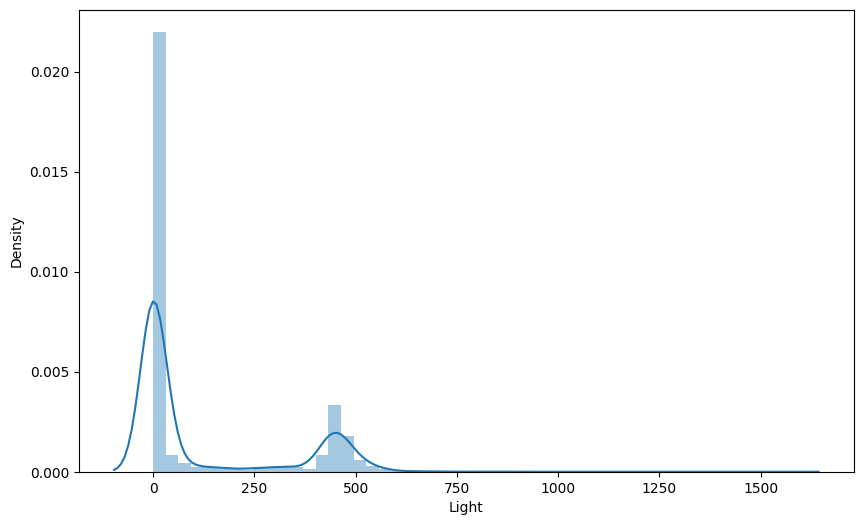

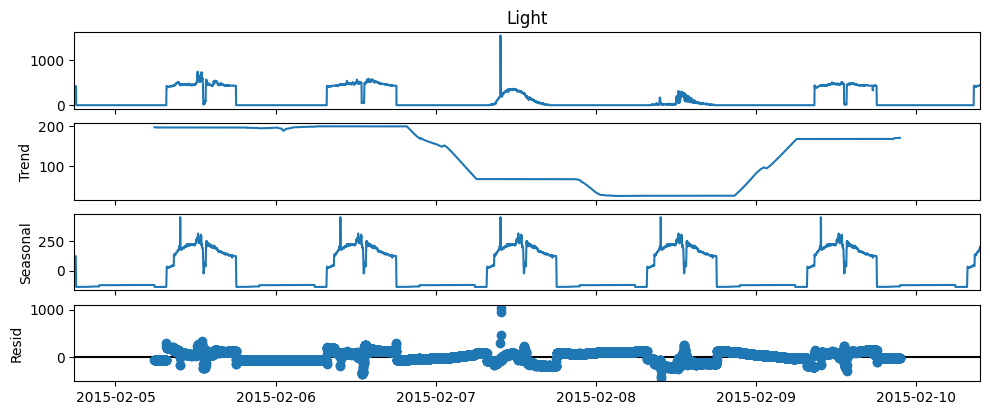

ADF Statistic: -3.314650
p-value: 0.014236
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Data does not have unit root and IS stationary (reject H0)


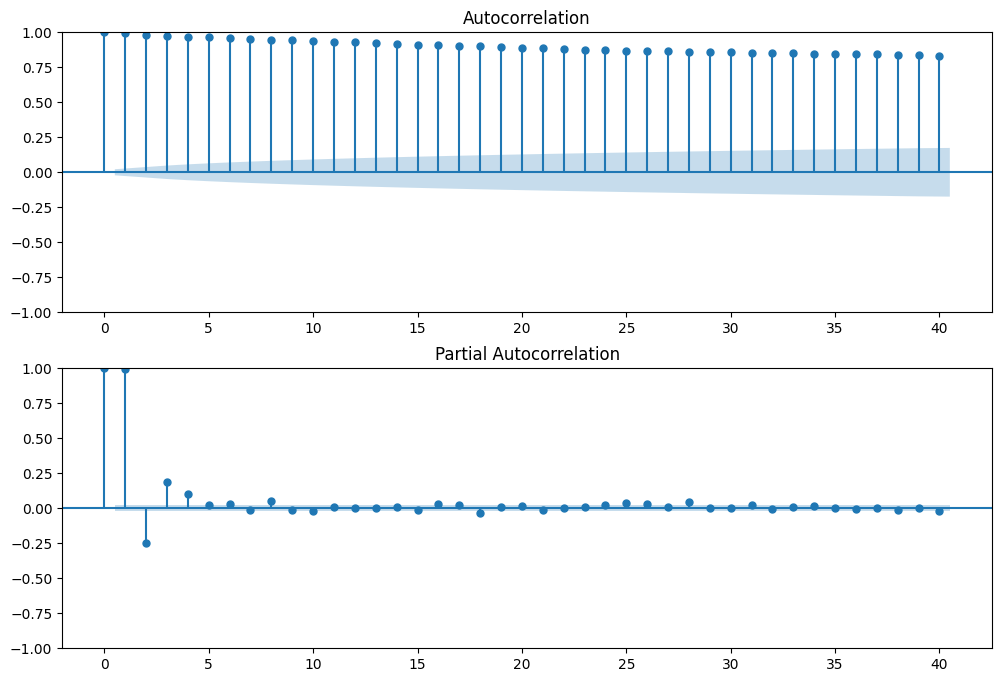

(8133, 10, 6) (8133,)
Epoch 1/15


c:\Users\yhan8\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 213.8344 - val_loss: 0.8092
Epoch 2/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.9801 - val_loss: 0.0692
Epoch 3/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9931 - val_loss: 0.0402
Epoch 4/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5942 - val_loss: 0.0324
Epoch 5/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5650 - val_loss: 0.0406
Epoch 6/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6182 - val_loss: 0.1255
Epoch 7/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4723 - val_loss: 0.0801
Epoch 8/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5513 - val_loss: 0.0776
Epoch 9/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4831 - val_loss: 1.9240
Epoch 10/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3779 - val_loss: 0.2458
Epoch 11/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4087 - val_loss: 0.7835
Epoch 12/15
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 

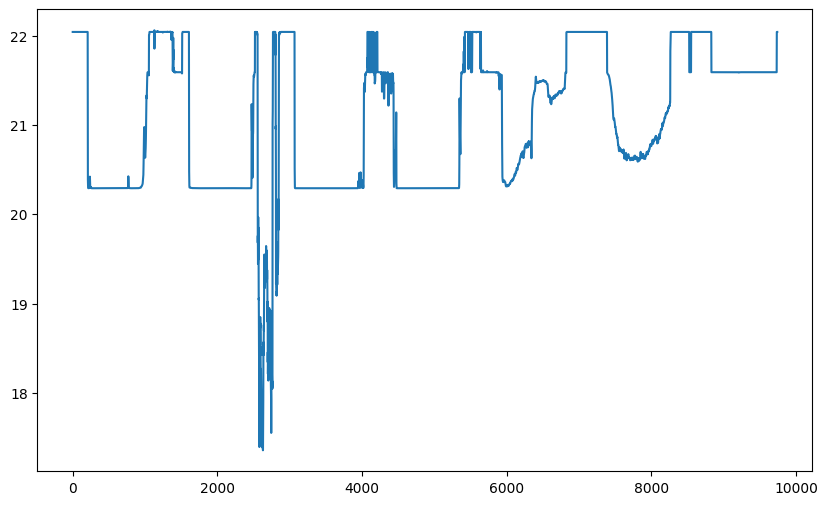

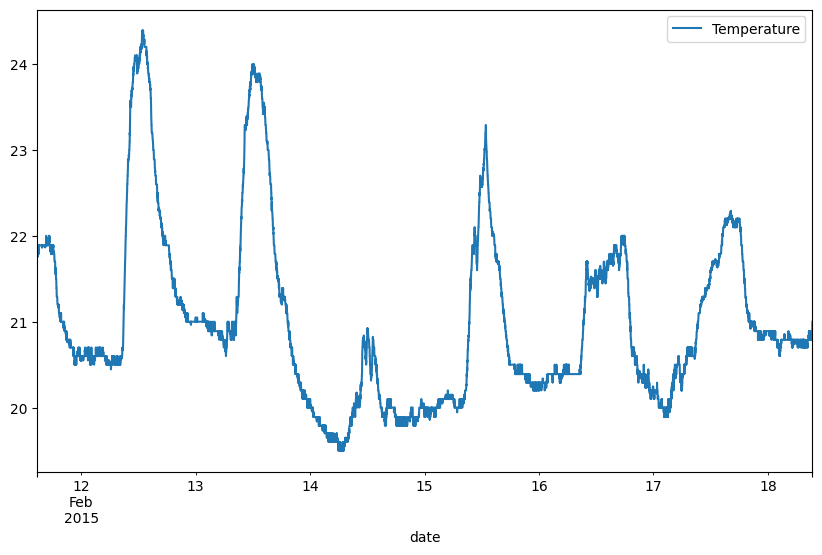

MSE: 1.139493
MAE: 0.717149
RMSE: 1.067471
SARIMA parameters to try:
SARIMAX: (0, 0, 1) x (0, 0, 1, 1440)
SARIMAX: (0, 0, 1) x (0, 1, 0, 1440)
SARIMAX: (0, 1, 0) x (0, 1, 1, 1440)
SARIMAX: (0, 1, 0) x (1, 0, 0, 1440)
ARIMA(0, 0, 0)x(0, 0, 0, 1440)1440 - AIC:72415.58403256017


c:\Users\yhan8\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [10]:
plt.rcParams['figure.figsize'] = [10.0, 6.0]
get_ipython().run_line_magic('matplotlib', 'inline')

# Read in data
df_train = pd.read_csv('train_data.txt') # 8143 rows
df_val = pd.read_csv('validation_data.txt') # 9752 rows

# Set random seed for reproducibility
tf.random.set_seed(42)


# ### Part 1: Forecast a univariate time series

def set_index(df):
    """ Input: Pandas dataframe object.
    Output: Converts date column to datetime object, sets as index, and rounds to nearest minute."""
    # Convert date column to datetime object
    df['date'] = pd.to_datetime(df['date'])

    # Set date to index and round to nearest minute for time series analysis
    df = df.set_index('date')
    df.index = df.index.round('min')
    return df

df_train = set_index(df_train)
df_train.head()

# Plot parameters
df_train.plot(subplots=True, figsize=(15,10))
plt.show()


# Perform checks for normality, skewness, kurtosis, seasonality, and stationarity.

def checks(series):
    """ Input: Pandas series.
        Output: Performs normality, skewness, kurtosis, seasonality decomposition, ADF tests, ACF and PACF plots"""
    # Normality Test
    stat, p = stats.normaltest(series)
    print('s^2 + k^2=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Data looks Gaussian (fail to reject H0)')
    else:
        print('Data does NOT look Gaussian (reject H0)')

    # Skewness and Kurtosis Tests
    sns.distplot(series);
    print('Kurtosis of normal distribution: {}'.format(stats.kurtosis(series)))
    print('Skewness of normal distribution: {}'.format(stats.skew(series)))

    # Seasonality decomposition, period = 1 day
    seas_d = seasonal_decompose(series, period = (60*24))
    fig=seas_d.plot()
    fig.set_figheight(4)
    plt.show()

    # ADF Test for Stationarity
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] > alpha:
        print('Data has unit root and is NOT stationary (fail to reject H0)')
    else:
        print('Data does not have unit root and IS stationary (reject H0)')

    # Plot ACF and PACF
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, ax=ax2)
    plt.show()


# Perform checks on Temperature
checks(df_train.Temperature)

# Perform checks on CO2
checks(df_train.CO2)


# Perform checks on Light
checks(df_train.Light)


# ACF Plot is slowly decreasing across lags, which is indicative of an AR process.

# ### Data Preprocessing

# Write function to predict the value at the current time step by using the history (n time steps from it).

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Set index for validation dataset
df_val = set_index(df_val)
df_val.head()


# Use a history of 10 time steps to make sequences:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(df_train, df_train.Temperature, time_steps)
X_test, y_test = create_dataset(df_val, df_val.Temperature, time_steps)

print(X_train.shape, y_train.shape)


# ### Modeling

# Use the LSTM layer in a sequential model to make predictions:

model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)


# ### Training

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

# Predict on test set
y_pred = model.predict(X_test)


plt.plot(y_pred)

y_pred_new = np.insert(y_pred, 0, np.repeat(np.nan, 10))
print(y_pred_new.shape)


df_val.plot(y='Temperature')
plt.show()

forecast_df = df_val
forecast_df['TempForecast'] = y_pred_new
forecast_df.plot(y=["Temperature", "TempForecast"], figsize=(15,4))

# Calculate Error Metrics of Temperature Forecast
mse = mean_squared_error(forecast_df.Temperature[10:], forecast_df.TempForecast[10:])
mae = mean_absolute_error(forecast_df.Temperature[10:], forecast_df.TempForecast[10:])
rmse = np.sqrt(mse)
print('MSE: %f' % mse)
print('MAE: %f' % mae)
print('RMSE: %f' % rmse)


# Modeling with SARIMAX

# Try range of p, d, q parameters for fit
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 1440) for x in list(itertools.product(p, d, q))]
print('SARIMA parameters to try:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# Calculate AIC
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_train.Temperature.values,order=param,seasonal_order=param_seasonal,enforce_stationarity=True,enforce_invertibility=True)
            results = mod.fit()
            print('ARIMA{}x{}1440 - AIC:{}'.format(param,param_seasonal,results.aic))
        except:
            continue


# Modeling with pmdarima auto_arima

# Fit model
model = pm.auto_arima(df_train.Temperature.values, seasonal=True, m=(60*24))